In [67]:
import numpy as np
import os
import pandas as pd
import rasterio
from rasterio.plot import show
import rasterio as rio
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from skimage.segmentation import quickshift
import skimage.data as data
import skimage.segmentation as seg
from skimage import filters
from skimage import draw
from skimage import color
from skimage import exposure
#own function
from functions_current import *
import time as time 
import scipy as sp

# fPCA packages
import skfda
from skfda.preprocessing.dim_reduction.projection import FPCA
from skfda import FDataGrid

In [2]:
#need for gaussian process example at least
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor

from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, ExpSineSquared, ConstantKernel
from sklearn.neighbors import LocalOutlierFactor

from scipy.interpolate import interp1d

In [6]:
path = '/home/ehe5bn/Documents/MSDS/Capstone/OfflineWork/northe_point_resampled_v1.csv.gz'
northe = pd.read_csv(path)

In [7]:
northe.head()

,Unnamed: 0,coastal_blue,blue,turquoise,green,yellow,red,red_edge,infrared,clear,...,udm1,x,y,year,month,day,hour,minute,seconds,time
0,0,710.13,743.13,911.63,1004.18,983.13,842.59,1481.72,2842.43,1.0,...,0.0,0.0,0.0,2020.0,4.0,19.0,15.0,12.0,37.0,2020.299546
1,1,281.99,280.44,475.72,508.00,399.37,308.44,833.24,3944.92,1.0,...,0.0,0.0,0.0,2020.0,6.0,9.0,15.0,12.0,7.0,2020.438889
2,2,90.49,117.00,275.33,315.86,238.65,172.14,572.14,3356.65,1.0,...,0.0,0.0,0.0,2020.0,7.0,13.0,15.0,16.0,12.0,2020.531793
3,3,103.97,156.40,299.12,332.52,255.98,203.23,620.71,3257.40,1.0,...,0.0,0.0,0.0,2020.0,7.0,20.0,15.0,18.0,7.0,2020.550922
4,4,169.37,171.85,323.94,372.86,282.39,207.59,635.55,3299.65,1.0,...,0.0,0.0,0.0,2020.0,7.0,26.0,15.0,12.0,3.0,2020.567304


## Part 1: Running fPCA on downsampled data (red band here)

In [25]:
red_only = northe[northe['udm1'] > 0.5]

In [26]:
# Filtering to only red band right now
red_only = northe[['red','x','y','time']]

In [27]:
red_only

,red,x,y,time
0,842.59,0.0,0.0,2020.299546
1,308.44,0.0,0.0,2020.438889
2,172.14,0.0,0.0,2020.531793
3,203.23,0.0,0.0,2020.550922
4,207.59,0.0,0.0,2020.567304
...,...,...,...,...
1845515,130.65,67.0,117.0,2024.996308
1845516,449.87,67.0,117.0,2025.001776
1845517,1799.65,67.0,117.0,2025.018212
1845518,2050.68,67.0,117.0,2025.029257


In [45]:
# Extract unique time points and coordinates
unique_times = np.sort(red_only['time'].unique())
unique_x_coords = np.sort(red_only['x'].unique())
unique_y_coords = np.sort(red_only['y'].unique())

n_times = len(unique_times)
num_pixels = len(unique_x_coords) * len(unique_y_coords)

# Initialize a matrix to store spectral values
data_matrix = np.zeros((num_pixels, n_times))

# Dictionary to map (x, y) to row index in data_matrix
pixel_index = {}
counter = 0
for x in unique_x_coords:
    for y in unique_y_coords:
        pixel_index[(x, y)] = counter
        counter += 1

# Populate the matrix with data
for i, row in red_only.iterrows():
    x, y, time, red = row['x'], row['y'], row['time'], row['red']
    time_idx = np.where(unique_times == time)[0][0]
    pixel_idx = pixel_index[(x, y)]
    data_matrix[pixel_idx, time_idx] = red

# Normalize time to [0, 1] TObias; O.k. but later we need to know what it is in year, when we model 
#only one year at a time 
time_points = np.linspace(0, 1, n_times)
#Tobias: thus x/y are ignored as it should be 
fd = FDataGrid(data_matrix, grid_points= time_points)

# Applying fPCA
n_components = 4  # number of components
fpca = FPCA(n_components=n_components)
scores = fpca.fit(fd)

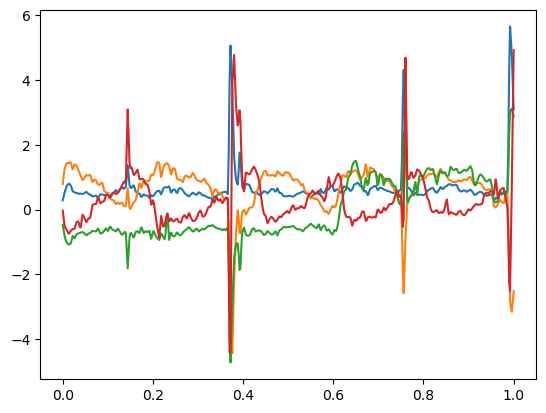

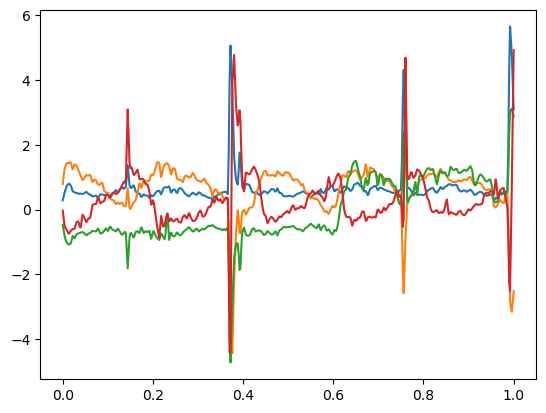

In [48]:
scores.components_.plot()

### Part 2: Reconstruction Errors

In [58]:
from skfda.misc.metrics import l2_distance, l2_norm
from scipy.stats import gaussian_kde

In [53]:
# Mapping and reverse mapping data to functional components to find distance to calc reconstruction error
data_set_hat = scores.inverse_transform(scores.transform(fd))

In [56]:
# Calculating Reconstruction Errors between actual data and mapped data
recon_error = l2_distance(
    fd,
    data_set_hat) / l2_norm(fd)

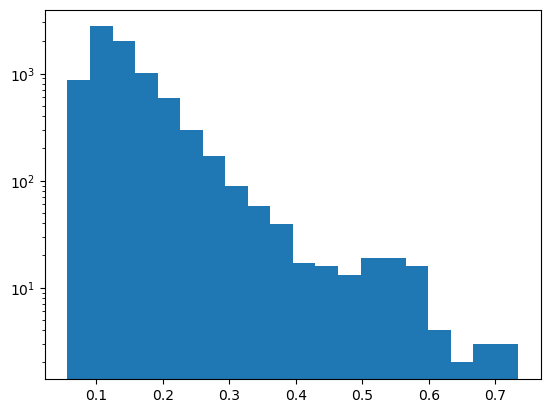

In [93]:
# Histogram of Reconstruction Errors
plt.hist(recon_error, bins = 20)
plt.yscale('log')

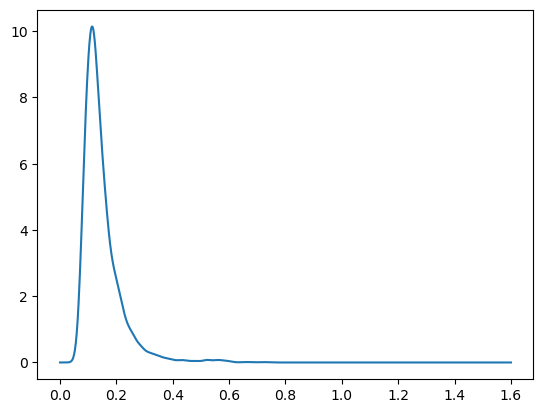

In [59]:
# Plotting Distributions of Reconstruction Errors
x_density = np.linspace(0., 1.6, num = 10**3)
density_data = gaussian_kde(recon_error)

plt.plot(x_density,
        density_data(x_density),
        label = "Reconstruction Error")

### Part 3: Mapping back to Image

In [76]:
dates,xydata,rdata,meta=reshape_for_ccdc(northe,exclude_start=0,exclude_end=0, mode = 'slow')

forest element 2287 has outlier classification 0
lake element 667 has outlier classification 0
building element 1426 has outlier classification 0
meadow element 1499 has outlier classification 0
construction element 3008 has outlier classification 0
logging element 270 has outlier classification 0


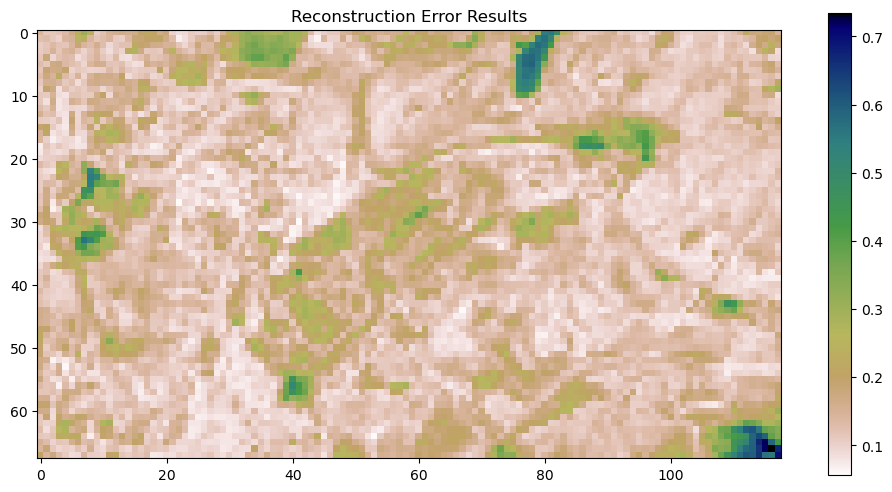

In [79]:
examples=[[45,19],[77,5],[10,12],[83,12],[58,25],[34,2]]
list_type=['forest','lake','building','meadow','construction','logging']
list_ex=coords_el(examples,xydata)
vis_outlier_regular(recon_error,xydata,direct=True,list_type=list_type,list_ex=list_ex,add_title='Reconstruction Error Results')

#### Comparing Above Reconstruction Error with Actual Images

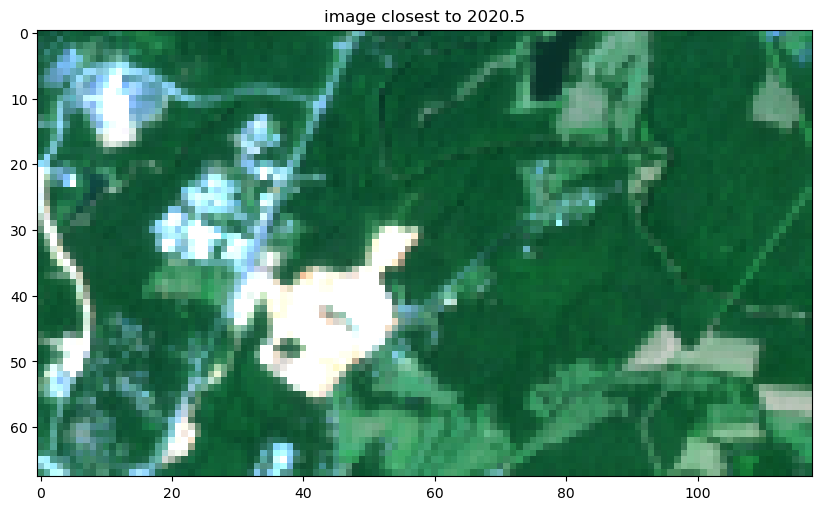

In [92]:
display_image_back(northe,time_axis_direct = False, time_date = 2020.5)

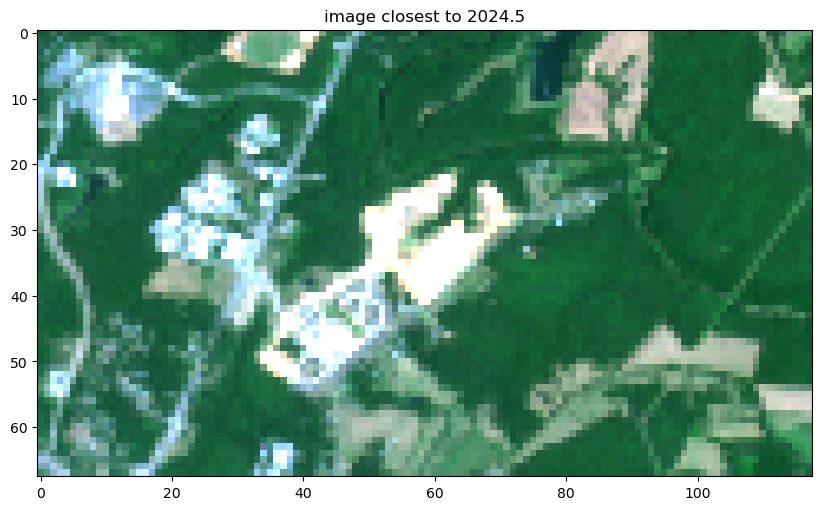

In [89]:
display_image_back(northe,time_axis_direct = False, time_date = 2024.5)

In [99]:
red_only.query('time >= 2020 and time < 2021')

,red,x,y,time
0,842.59,0.0,0.0,2020.299546
1,308.44,0.0,0.0,2020.438889
2,172.14,0.0,0.0,2020.531793
3,203.23,0.0,0.0,2020.550922
4,207.59,0.0,0.0,2020.567304
...,...,...,...,...
1845312,476.94,67.0,117.0,2020.930793
1845313,397.17,67.0,117.0,2020.944458
1845314,605.77,67.0,117.0,2020.955388
1845315,503.06,67.0,117.0,2020.988166


In [124]:
def testing(dataframe, band_filter, start_time = 2020, end_time = 2026):
    ''' this function takes in a dataframe with a specific band filter (str) and defaults to 4 components for fPCA.
    
        Data frame should have band, x/y coordinate info (column names need to be 'x' and 'y'), and time (column name needs to be 'time')
        band filter: a string of the name of the column for the band that you want to look at
        n_components: an integer that defines the number of components you want for running fPCA
        start_time: is the first date if you want to filter the beginning of a time period for fPCA
        end_time: is the last date if you want to filter the end of a time period for fPCA
        reconstruction_error_plot: Optional input to see histogram of the distribution of reconstruction errors from fPCA
        
        If you want to map reconstruction errors to original image, use reshape_for_ccdc() function first
        Second, use vis_outlier_regular(recon_error) function to see images
        '''
    
    df = dataframe.query(f'time >= {start_time} and time < {end_time}')
    df = df[[band_filter,'x','y','time']]
    return df

In [131]:
testing(northe, 'red', start_time = 2022, end_time = 2023)

,red,x,y,time
85,2316.17,0.0,0.0,2022.009948
86,2017.53,0.0,0.0,2022.020991
87,541.46,0.0,0.0,2022.026394
88,517.49,0.0,0.0,2022.031861
89,1216.48,0.0,0.0,2022.070307
...,...,...,...,...
1845418,404.06,67.0,117.0,2022.892129
1845419,470.05,67.0,117.0,2022.903153
1845420,439.33,67.0,117.0,2022.919621
1845421,510.07,67.0,117.0,2022.979896


In [145]:
def fPCA_reconstruction_error(dataframe, band_filter, start_time = 2020, end_time = 2026, n_components = 4, reconstruction_error_plot = False):
    ''' this function takes in a dataframe with a specific band filter (str) and defaults to 4 components for fPCA.
    
        Data frame should have band, x/y coordinate info (column names need to be 'x' and 'y'), and time (column name needs to be 'time')
        band filter: a string of the name of the column for the band that you want to look at
        n_components: an integer that defines the number of components you want for running fPCA
        start_time: is the first date if you want to filter the beginning of a time period for fPCA
        end_time: is the last date if you want to filter the end of a time period for fPCA
        reconstruction_error_plot: Optional input to see histogram of the distribution of reconstruction errors from fPCA
        
        If you want to map reconstruction errors to original image, use reshape_for_ccdc() function first
        Second, use vis_outlier_regular(recon_error) function to see images
        '''
    
    df = dataframe.query(f'time >= {start_time} and time < {end_time}')
    df = df[[band_filter,'x','y','time']]
    
    ## fPCA code here: ## 
    
    # Extract unique time points and coordinates
    unique_times = np.sort(df['time'].unique())
    unique_x_coords = np.sort(df['x'].unique())
    unique_y_coords = np.sort(df['y'].unique())
    n_times = len(unique_times)
    num_pixels = len(unique_x_coords) * len(unique_y_coords)

    # Initialize a matrix to store spectral values
    data_matrix = np.zeros((num_pixels, n_times))

    # Dictionary to map (x, y) to row index in data_matrix
    pixel_index = {}
    counter = 0
    for x in unique_x_coords:
        for y in unique_y_coords:
            pixel_index[(x, y)] = counter
            counter += 1

    # Populate the matrix with data
    for i, row in red_only.iterrows():
        x, y, time, band_choice = row['x'], row['y'], row['time'], row[band_filter]
        time_idx = np.where(unique_times == time)[0]
        pixel_idx = pixel_index[(x, y)]
        data_matrix[pixel_idx, time_idx] = band_choice

    # Normalizing time to [0, 1]
    time_points = np.linspace(0, 1, n_times)
    fd = FDataGrid(data_matrix, grid_points= time_points)

    # Applying fPCA
    fpca = FPCA(n_components=n_components)
    scores = fpca.fit(fd)  # NOTE: try using one year here and then a different year for below reconstruction calculations
    
    # Mapping and reverse mapping data to functional components to find distance to calc reconstruction error
    data_set_hat = scores.inverse_transform(scores.transform(fd))

    # Calculating Reconstruction Errors between actual data and mapped data
    recon_error = l2_distance(
        fd,
        data_set_hat) / l2_norm(fd)
    
    if reconstruction_error_plot == True:
        # Histogram of Reconstruction Errors
        plt.hist(recon_error, bins = 20)
        plt.yscale('log')
        
    

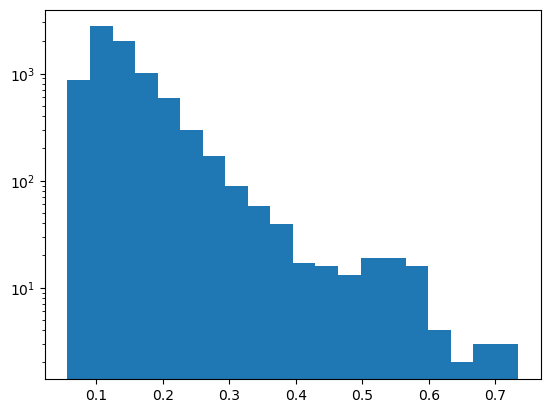

In [141]:
fPCA_reconstruction_error(northe, 'red', reconstruction_error_plot = True)

### Running function for each year

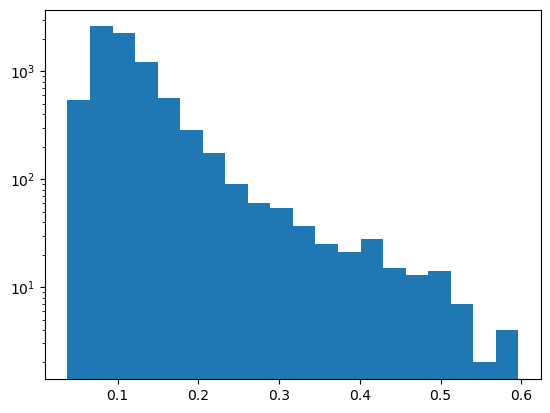

In [140]:
# 2021 only
fPCA_reconstruction_error(northe, 'red',start_time = 2021, end_time = 2022, reconstruction_error_plot = True)

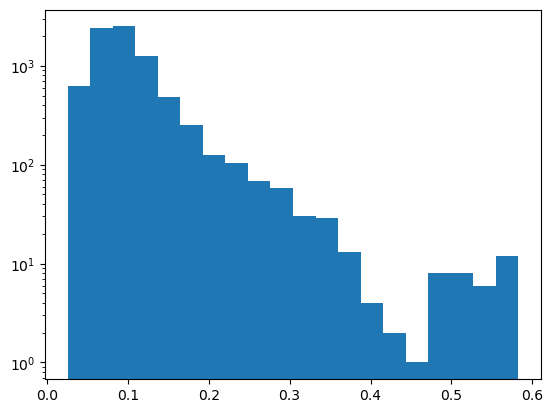

In [142]:
# 2022 only
fPCA_reconstruction_error(northe, 'red',start_time = 2022, end_time = 2023, reconstruction_error_plot = True)

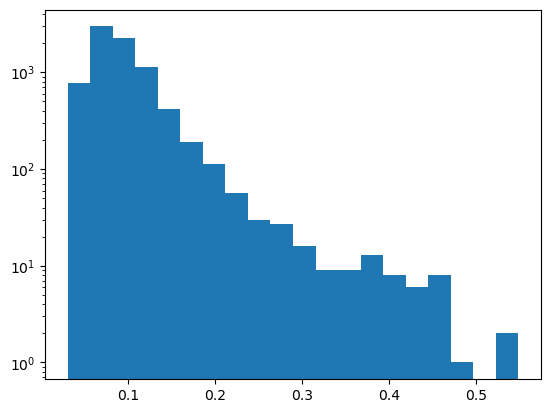

In [143]:
# 2023 only
fPCA_reconstruction_error(northe, 'red',start_time = 2023, end_time = 2024, reconstruction_error_plot = True)

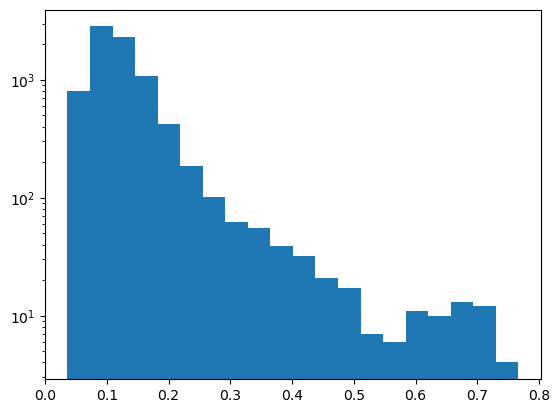

In [144]:
# 2024 only
fPCA_reconstruction_error(northe, 'red',start_time = 2024, end_time = 2025, reconstruction_error_plot = True)

### Notes
- difficult to detect anomalies
- try to normalize time first
- use different year for getting fPCA vs. reconstruction errors
- look at changing fPCA parameters (for when year doesn't work)
- could try to exclude snow better too